In [1]:
import itertools
import sys

import os

import h5py

import numpy as np

import matplotlib as mpl

import matplotlib.pyplot as plt

import matplotlib.animation as animation

import matplotlib.mlab as mlab

from matplotlib.ticker import MultipleLocator, LinearLocator, FormatStrFormatter, LogLocator, LogFormatterExponent

from matplotlib import cm

from matplotlib.colors import LogNorm

from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns

sns.set_style('darkgrid', {'axes.linewidth': '1', 'axes.edgecolor': '0.15'})
sns.set_style("ticks")
current_palette = sns.color_palette()

In [2]:
class mplot4d(object):
    def __init__(self, h5gridprefix = None, idb=0, idt=10, iqn = 26, iqp = 35):
        '''
        '''
        self.defpath = r'/home/ben/git/ndust/data/'

        self.h5gridprefix = h5gridprefix
        self.h5gridprefix = self.defpath + self.h5gridprefix

        # Read grid file
        self.gridfname = self.h5gridprefix + '.h5'
        self.gridfile =  h5py.File(self.gridfname, 'r')

        ## group volumes
        self.gvols = self.gridfile.get("Volume_sections")
        self.vifaces = np.array(self.gvols.get("Interfaces"))

        ## interfaces in diameters nm
        self.vifaces_diam = np.power(6.0*self.vifaces/np.pi, 1.0/3.0)*1E9

        ## WARNING diameter pivots in nanometres
        self.vpivots = np.array(self.gvols.get("Volumes"))

        ## pivots in diameters
        self.dpivots = np.array(self.gvols.get("Diameters"))*1E9

        ## group charges
        self.gchgs = self.gridfile.get("Charge_sections")

        self.qpivots = np.array(self.gchgs.get("Charges"))
        #self.qifaces = np.append()
        #np.array(self.gchgs.get("qifaces"))

        self.idb = []
        self.idt = []
        self.iqn = []
        self.iqp = []
        self.set_grid(idb, idt, iqn, iqp)

        self.gcoagulation = self.gridfile.get("Coagulation_rate")
        self.gefactor = self.gridfile.get("Enhancement_factor")
        self.loglevels = np.array([0, 1, 20, 50, 100, 200, 500])
        self.hatches=['/', *[None]*(len(self.loglevels)-1)]

    def set_grid(self, idb, idt, iqn, iqp):
        self.idb = idb# index for minimum diameter
        self.idt = idt# index for maximum diameter
        self.iqn = iqn# index for negative charges
        self.iqp = iqp# index for positive charges
        # make grid
        self.X, self.Y = np.meshgrid(self.dpivots[idb:idt], self.qpivots[iqn:iqp])
        self.extents_linear = [0, len(self.dpivots[idb:idt]), 0, len(self.qpivots[iqn:iqp])]

    def get(self, name):
        efactor = np.array(self.gefactor.get(name))
        # get one dataset for testing    
        result = np.array(self.gcoagulation.get(name))
        res_gt_0 = result > 0
        log10res = np.zeros_like(result)
        log10res[res_gt_0] = np.log10(result[res_gt_0])
        return result, log10res, efactor

    def close(self):
        self.gridfile.close()

    def plot_fcontours(self, ax, data, levelsf=None, cmap=cm.plasma):
        """
        """
        if levelsf is None:
            levelsf = np.arange(1, 18, 2)

        norm = mpl.colors.Normalize(vmin=levelsf[0], vmax=levelsf[-1])
        
        # restrict data to grid
        datagrid = data[self.iqn:self.iqp, self.idb:self.idt]
#     self.axis(axislabel)
#     self.minorticks(fig)


#     CSF = ax.pcolormesh(X, Y, data, cmap=cmap)#,
#                       #extent=self.extents_linear)

#         CSF = ax.contourf(self.X[25:], self.Y[25:], data[25:], levelsf, cmap=cmap, origin='lower', norm=norm,
#                       extent=self.extents_linear)
#         CS = ax.contour(self.X[25:], self.Y[25:], data[25:], levels=levelsf, origin='lower',
#                     colors='k', linewidths=1.5)
        CSF = ax.contourf(self.X, self.Y, datagrid, levelsf, cmap=cmap,
                          origin='lower', norm=norm, extent=self.extents_linear,
                          hatches=self.hatches, extend='max')
        CS = ax.contour(self.X, self.Y, datagrid, levels=levelsf, origin='lower',
                        colors='k', linewidths=1.5)
        return CSF, CS
    def plot(self, llist, qlist, levelsf=np.logspace(0, 3, 20), xaxticks=None, filename='name'):
        data = []
        combinations = np.array(np.meshgrid(llist, qlist)).T.reshape(-1, 2)
#     for cpair in combinations:
        
        for ll in llist:
            for ql in qlist:
                # iterate in datasets of gefactor
                for ds in self.gefactor.keys():
                    lp = self.gefactor.get(str(ds)).attrs.get('l')
                    qp = self.gefactor.get(str(ds)).attrs.get('q')
                    if(ll==lp and ql==qp):
                        #print(ll, ql)
                        data.append(np.array(self.gefactor.get(str(ds))))
                        #print(np.array(m4d.gefactor.get(str(ds))).shape)
#         data.append(self.get(rl)[2])

        fig, axes = plt.subplots(nrows=len(qlist), ncols=len(llist), figsize=(len(qlist)*4.5, len(llist)*3.5))
#     plt.setp(axes.flat, xticks=[], yticks=[])

        for ax in axes.flat:
            # Hide all ticks and labels
            ax.xaxis.set_visible(False)
            ax.yaxis.set_visible(False)

#         # Set up ticks only on one side for the "edge" subplots...
#         if ax.is_first_col():
#             ax.yaxis.set_ticks_position('left')
#         if ax.is_last_col():
#             ax.yaxis.set_ticks_position('left')
#         if ax.is_first_row():
#             ax.xaxis.set_ticks_position('bottom')
#         if ax.is_last_row():
#             ax.xaxis.set_ticks_position('bottom')
            
        i=0
        for col, l in zip(axes.T, llist):
            for ax, q in zip(col, qlist):        
                CSF, CS = self.plot_fcontours(ax, data[i], levelsf=self.loglevels, cmap=cm.gist_heat_r)
                i = i+1

    # for ax, r in zip(axes[0], r1):    
    #     for ax, q in zip(axes[:, -1], q1):
    #         plot_fcontours(ax, m4d.X, m4d.Y, ef28, levelsf=np.logspace(0, 3, 20))
    # Label rows and columns

#     for ax, l in zip(axes[0], llist):
#         ax.set_title(str(self.dpivots[l]), size=14)
#         ax.yaxis.set_visible(True)

#     for ax, q in zip(axes[:, -1], qlist):
#         ax.set_ylabel(str(self.qpivots[q]), size=14)
#         ax.yaxis.set_label_position("right")
#         ax.get_yaxis().set_ticks([])
#         ax.yaxis.set_visible(True)


#     for ax, q in zip(axes[:, 0], qlist):
#         ax.set_ylabel('Charge of particle 1', size=14)
#         #ax.yaxis.set_label_position("left")
#         ax.yaxis.set_ticks_position('left')
#         ax.yaxis.set_visible(True)
        
#     for ax, l in zip(axes[len(llist)-1], llist):
#         ax.xaxis.set_ticks_position('bottom')
#         ax.set_xlabel('Diameter of particle 1', size=14)
#         ax.xaxis.set_visible(True)
        axes[len(col)-1, 0].xaxis.set_visible(True)
        axes[len(col)-1, 0].set_xlabel('Diameter of particle 1 (nm)', size=16)
        axes[len(col)-1, 0].yaxis.set_visible(True)
        axes[len(col)-1, 0].set_ylabel('Charge of particle 1 (#e)', size=16)
        axes[len(col)-1, 0].yaxis.set_ticks_position('left')
        for ax in axes.flat:
            ax.xaxis.set_visible(True)
            ax.yaxis.set_visible(True)
            ax.xaxis.set_ticks_position('bottom')
            ax.yaxis.set_ticks_position('left')
            for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(14)
            ax.set_yticks(self.Y[:, 0])
            if xaxticks:
                ax.set_xticks(xaxticks)
            for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(14)
            for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(14)
            #ax.get_xaxis().set_tick_params(direction='out', width=5)
            #ax.get_yaxis().set_tick_params(direction='out', width=1)
                
        for ax, l in zip(axes[0], llist):
            ax.set_title('{:.1f}'.format((self.dpivots[l])), size=16)
            ax.yaxis.set_visible(True)

        for ax, q in zip(axes[:, -1], qlist):
            ax.set_ylabel('{:+.0f}'.format((self.qpivots[q])), size=16, rotation=270, labelpad=20)
            ax.yaxis.set_label_position("right")
            ax.xaxis.set_visible(True)
            for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(14)
        
# #     Turn on the proper x or y axes ticks.
#     for i, j in zip(range(numvars), itertools.cycle((-1, 0))):
#         axes[j,i].xaxis.set_visible(True)
#         axes[i,j].yaxis.set_visible(True)

#     print(axes)
#     [axes[len(llist)-1, j].xaxis.set_visible(True) for j in llist]
# fig.colorbar(im, ax=axes.ravel().tolist())
        plt.gcf().text(0.3, 0.92,"Diameter of particle 2 (nm)", ha="left", fontsize=20)
        plt.gcf().text(0.72, 0.64,"Charge of particle 2 (#e)", ha="left", fontsize=20, rotation=-90)
        CB = fig.colorbar(CSF, ax=axes.ravel().tolist(), pad=0.12)
        #    CB.ax.set_ylabel(axislabel[2], fontsize=self.xc.label_fontsize1)
        #     CB.ax.tick_params(labelsize=self.xc.tick_fontsize)
        CB.add_lines(CS)
        CB.ax.set_ylabel('Enhancement factor', rotation=270, fontsize=20, labelpad=20)
        CB.ax.tick_params(labelsize=14)

        #     plt.suptitle("Radii of particle 2")
        plt.savefig(filename+'.eps')
        plt.show()


In [3]:
m4d = mplot4d("grid-geom-IPA-force")


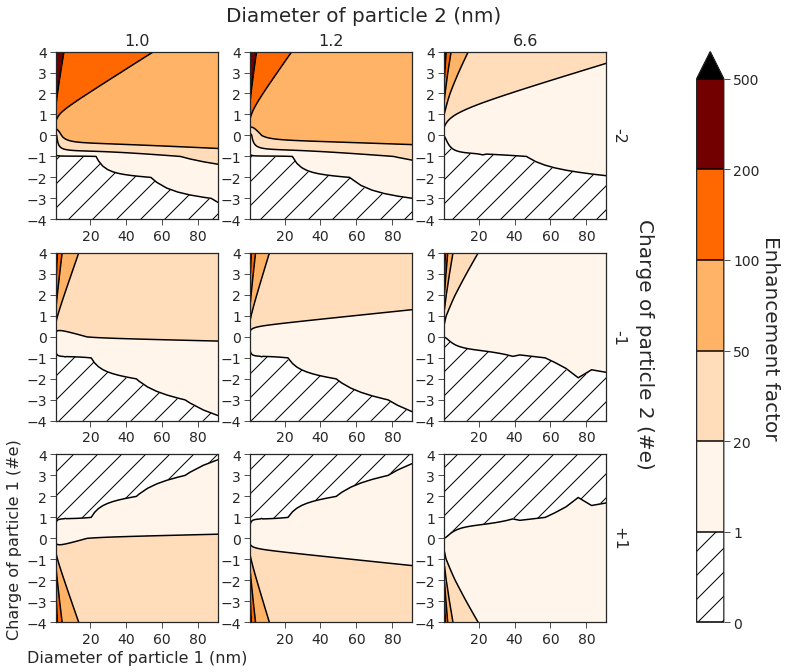

In [4]:
# ll=[0, 1, 2]
ll=[0, 2, 20]
ql=[28, 29, 31]
m4d.set_grid(0, 49, 26, 35)
m4d.plot(ll, ql)

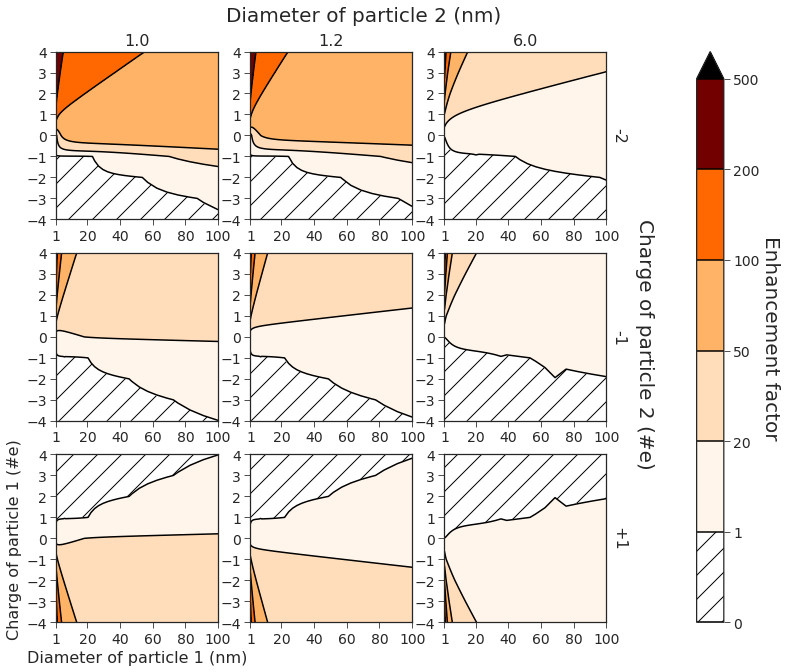

In [5]:
# ll=[0, 1, 2]
ll=[0, 2, 19]
ql=[28, 29, 31]
m4d.set_grid(0, 50, 26, 35)
# set xaxis
m4d.plot(ll, ql, xaxticks=[1, *np.arange(20, 120, 20)], filename='figure4')

In [6]:
m4d.dpivots[42]

51.799473

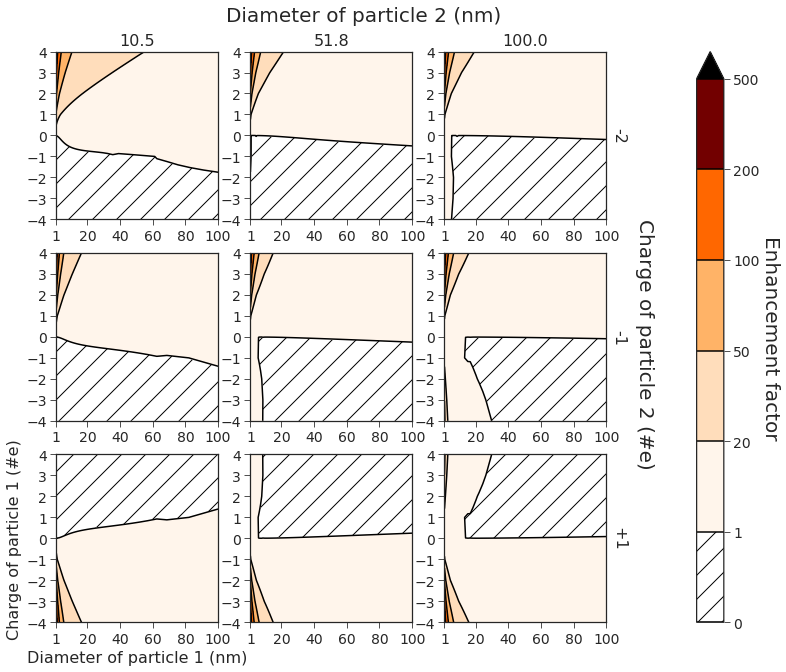

In [7]:
# ll=[0, 1, 2]
ll=[25, 42, 49]
ql=[28, 29, 31]
m4d.set_grid(0, 50, 26, 35)
# set xaxis
m4d.plot(ll, ql, xaxticks=[1, *np.arange(20, 120, 20)], filename='figure5')

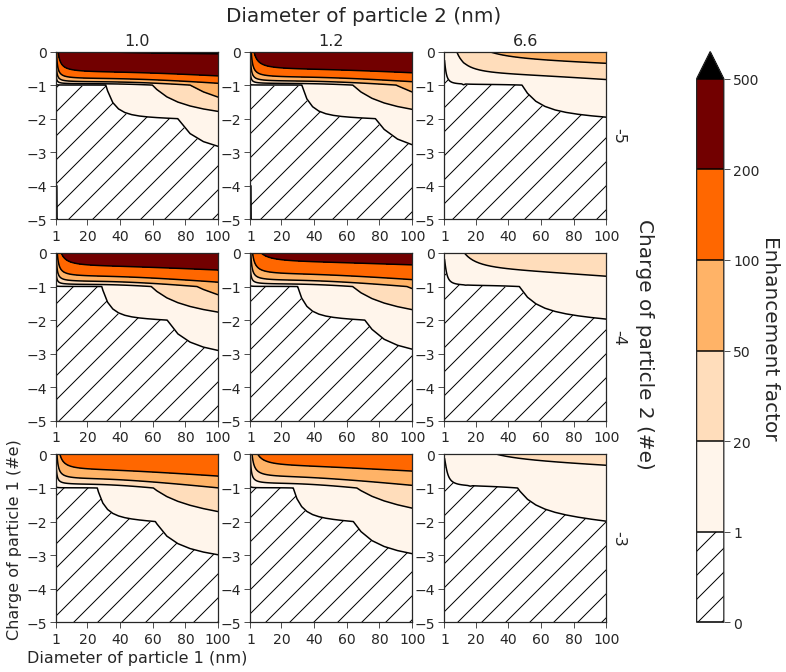

In [8]:
# ll=[0, 1, 2]
ll=[0, 2, 20]
ql=[25, 26, 27]
m4d.set_grid(0, 50, 25, 31)
# set xaxis
m4d.plot(ll, ql, xaxticks=[1, *np.arange(20, 120, 20)])#, filename='figure5')

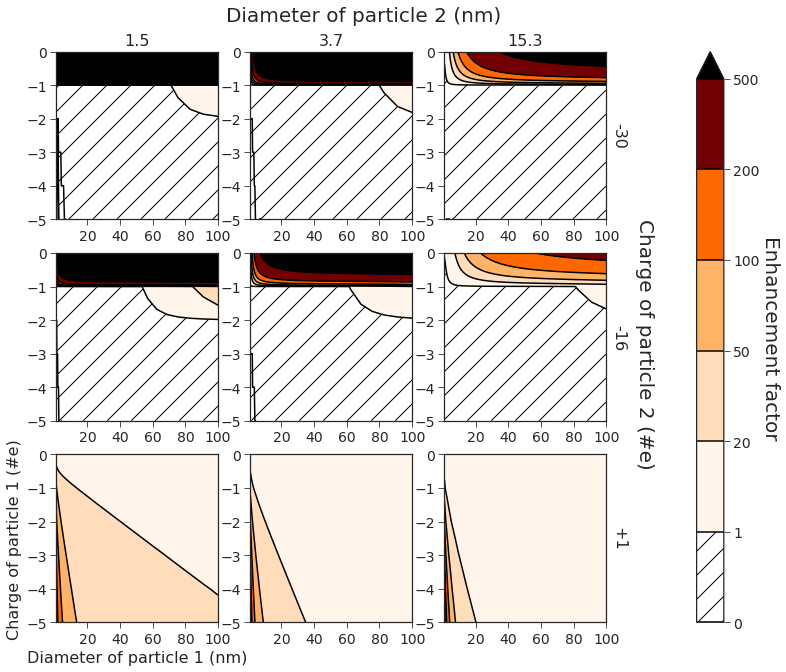

In [9]:
ll=[4, 14, 29]
#ql=[28, 29, 31]
ql=[0, 14, 31]
m4d.qneg = 0
m4d.plot(ll, ql)

In [10]:
m4d.close()

In [11]:
m4dmpc = mplot4d("grid-geom-MPC-force-20terms")


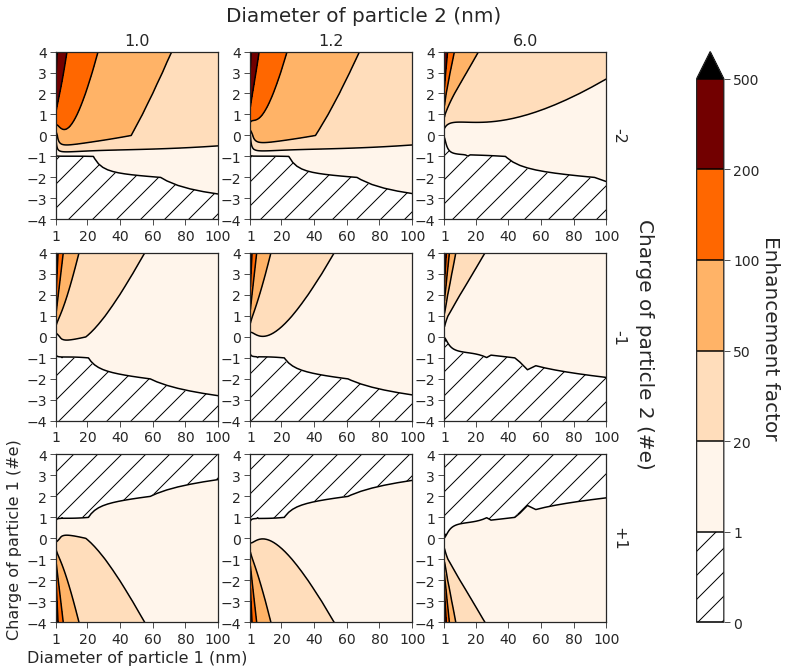

In [12]:
# ll=[0, 1, 2]
ll=[0, 2, 19]
ql=[28, 29, 31]
m4dmpc.set_grid(0, 50, 26, 35)
# set xaxis
m4dmpc.plot(ll, ql, xaxticks=[1, *np.arange(20, 120, 20)], filename='figure2')

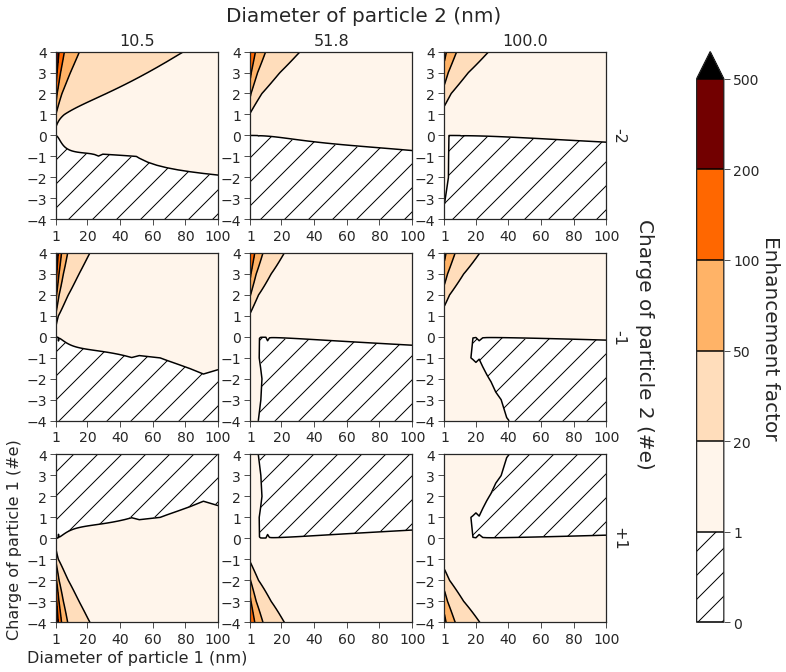

In [13]:
# ll=[0, 1, 2]
ll=[25, 42, 49]
ql=[28, 29, 31]
m4dmpc.set_grid(0, 50, 26, 35)
# set xaxis
m4dmpc.plot(ll, ql, xaxticks=[1, *np.arange(20, 120, 20)], filename='figure3')

In [14]:
m4dmpc.close()

In [15]:
m4dc = mplot4d("grid-geom-coulomb")

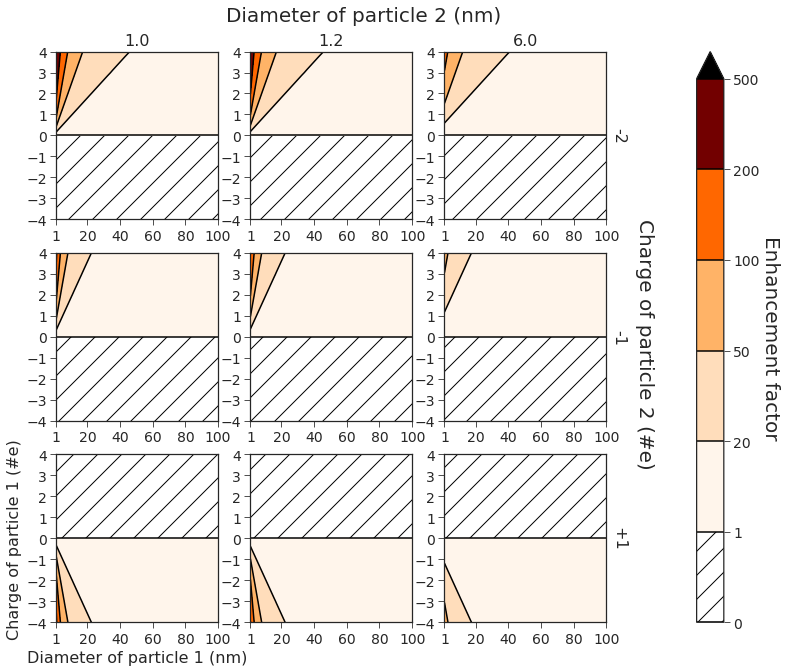

In [16]:
# ll=[0, 1, 2]
ll=[0, 2, 19]
ql=[28, 29, 31]
m4dc.set_grid(0, 50, 26, 35)
# set xaxis
m4dc.plot(ll, ql, xaxticks=[1, *np.arange(20, 120, 20)], filename='figure1')


In [17]:
m4dc.close()